In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time
import seaborn as sns
from sklearn import tree
from matplotlib import rcParams
from matplotlib.colors import LogNorm

In [ ]:
sns.set_theme(style="whitegrid")
data_loc = 'data/Seagrass_data'
data = pd.read_csv(os.path.join(data_loc,'presence.txt'), sep='\t')
data.head()

In [12]:
data = data.append(pd.read_csv(os.path.join(data_loc,'absence.txt'), sep='\t'))
data.tail()

,ID,BIO_CLASS,LONGITUDE,LATITUDE,VOTEMPER_2015-01-01,VOTEMPER_2015-02-01,VOTEMPER_2015-03-01,VOTEMPER_2015-04-01,VOTEMPER_2015-05-01,VOTEMPER_2015-06-01,...,maxVHM0_year,minVHM0_year,Med_bathym,Distance_to_Major_Cities,Distance_to_Complete_Cities,Distance_to_Port,Distance_to_Major_River,Distance_to_Complete_River,Distance_to_Coast,Substrate
1279,3051,absence,10.125122,37.375122,15.6303,14.5628,14.3054,15.5659,19.0712,21.9298,...,4.25250,0.195472,-42.0965,0.274420,0.150311,0.258625,4.849094,0.212665,0.017269,Sand
1280,3052,absence,3.250122,43.187500,11.5676,10.3195,11.3529,14.1589,16.5947,20.5906,...,1.77448,0.101832,-19.6500,0.749963,0.061738,0.250679,0.937638,0.028006,0.026280,Posidonia oceanica meadows
1281,3053,absence,3.187500,43.125122,11.7245,10.3866,11.3739,14.1857,16.6250,20.6031,...,1.82766,0.107592,-25.6056,0.837094,0.042127,0.162368,0.986339,0.100672,0.035605,Fine mud
1282,3054,absence,10.062500,42.750122,15.3494,14.1617,13.7828,15.1990,18.5931,23.2556,...,1.53456,0.132567,-104.9610,1.541257,0.037500,0.278889,2.135481,0.553487,0.043926,Fine mud
1283,3055,absence,11.062500,42.375122,15.3636,13.9891,13.7805,15.1191,18.5357,22.9824,...,1.28202,0.139658,-93.0303,1.413929,0.079515,0.079515,1.181068,0.136423,0.036075,Muddy sand


In [13]:
## Wrangle Temporal Data and Use Summaries
## Drop ID field
data = data.drop(columns = 'ID')
data = data.drop(columns = 'LONGITUDE')
data = data.drop(columns = 'LATITUDE')
## Drop monthly measurements
temporalVars = [var for var in data.columns if '-01' in var]
data = data.drop(columns = temporalVars)

## Drop 
seasonalVars = [var for var in data.columns if '2015' in var and 'year' not in var]
data = data.drop(columns = seasonalVars)
data.head()

## Extreme Vars 
extremeVars = [var for var in data.columns if 'max' in var or 'min' in var]
data = data.drop(columns = extremeVars)
data.head()

## Make Columns Human-Readable

data = data.rename(columns={'BIO_CLASS':'Species Name','VOTEMPER_2015_year':'Temperature',
            'VOSALINE_2015_year':'Salinity', 'CHL_2015_year':'Chlorophyll',
            'NIT_2015_year':'Nitrate', 'ZSD_2015_year':'Secchi Disk Depth',
            'PHO_2015_year':'Phosphate', 'VHM0_2015_year':'Wave Height',
            'Med_bathym':'Water Depth', 'Distance_to_Major_Cities':'Dist. to Major City',
            'Distance_to_Complete_Cities': 'Dist. to City','Distance_to_Port':'Dist. to Port',
            'Distance_to_Major_River': 'Dist. Major River', 'Distance_to_Complete_River': 'Dist. to River',
            'Distance_to_Coast':'Dist. to Coast'})
data.head()

## Drop Water Depth More than 90 m (Seagrasses cannot live past 90 m depth)
data.drop(data[data['Water Depth']<-90].index, inplace=True)

In [14]:
data.head()

,Species Name,Temperature,Salinity,Chlorophyll,Nitrate,Secchi Disk Depth,Phosphate,Wave Height,Water Depth,Dist. to Major City,Dist. to City,Dist. to Port,Dist. Major River,Dist. to River,Dist. to Coast,Substrate
0,Zostera noltii,18.538867,36.531583,0.140348,0.434333,10.583319,0.052310,0.429572,-11.2309,0.087600,0.005301,0.037467,1.079964,0.017832,0.002332,Sand
1,Zostera noltii,20.416100,37.364708,0.140348,0.077374,18.485917,0.014889,0.472164,-6.8000,0.442909,0.014262,0.286160,1.622614,0.027839,0.000076,Unknown
2,Zostera noltii,17.193558,38.131142,0.382871,0.687794,10.885297,0.021145,0.609442,-10.3056,1.318053,0.027334,0.088994,1.168450,0.006448,0.008452,Dead mattes of Posidonia oceanica
3,Zostera noltii,17.159158,38.130325,0.382871,0.653306,11.463670,0.020927,0.609442,-11.2222,1.282608,0.014240,0.131290,1.164785,0.017996,0.011845,Fine mud
4,Zostera noltii,17.122192,38.130475,0.382871,0.644144,11.696177,0.020042,0.609442,-10.2917,1.249612,0.022728,0.172756,1.165509,0.012884,0.009731,Fine mud


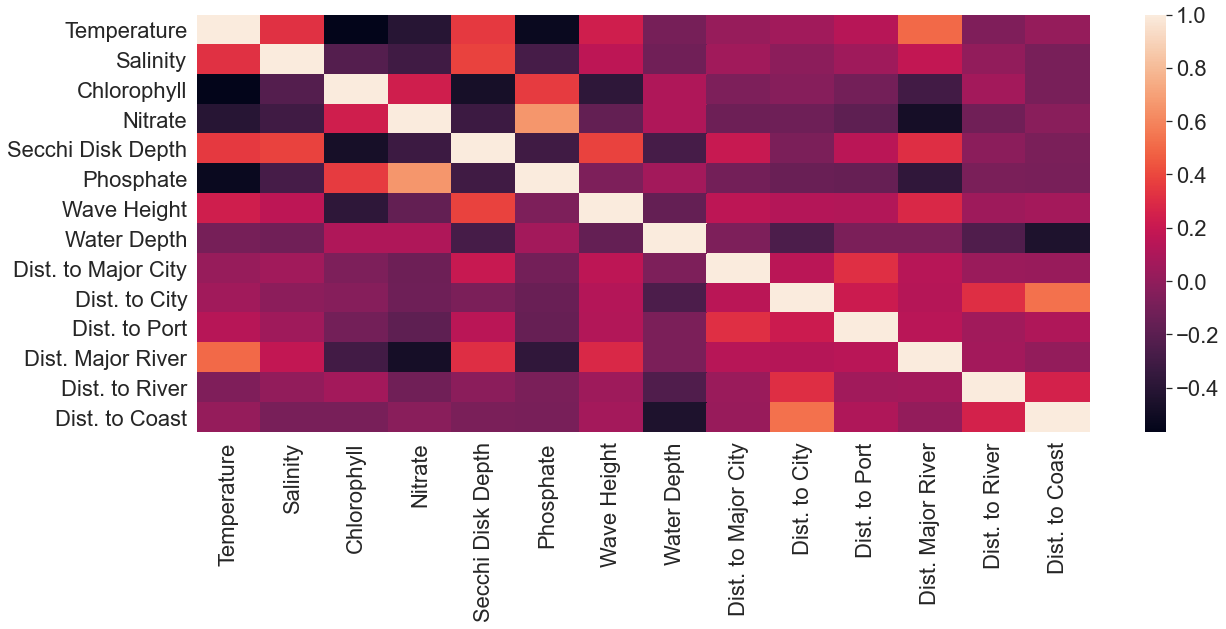

In [6]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)
corr = data[3:].corr(method = 'spearman')

sns.heatmap(corr, annot=False)

plt.savefig('figs/sea_Seagrass_spearman_mat.png', dpi=300)

In [15]:
## Standardize Data for Plotting
x = data[data.columns[1:-1]].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = data.columns[1:-1]
df[data.columns[0]] = data[data.columns[0]].values

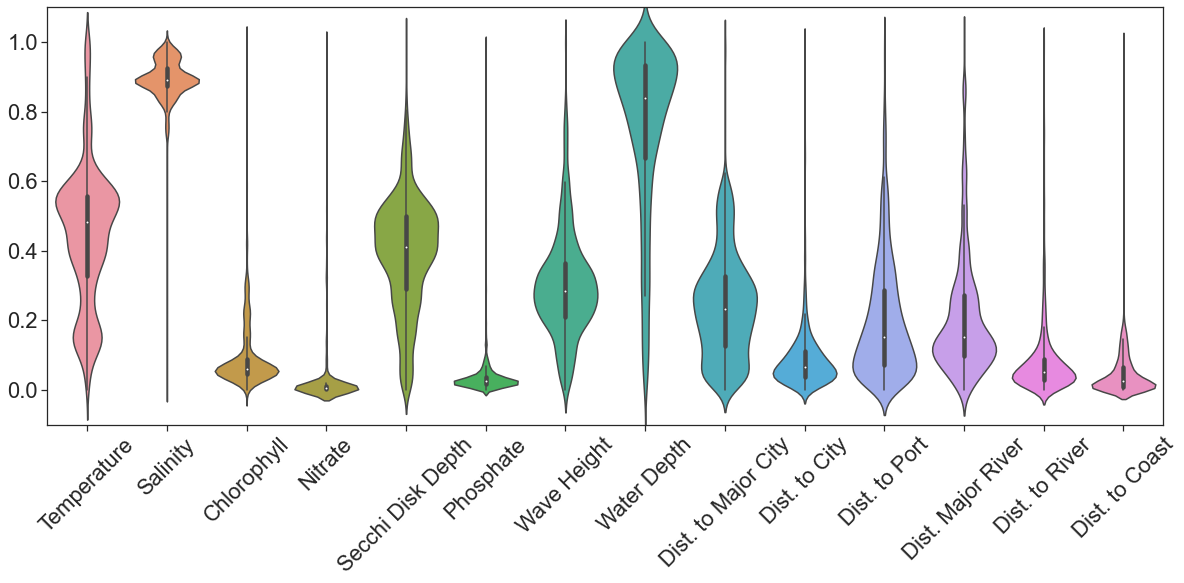

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("ticks")
plt.gcf().subplots_adjust(bottom=0.30)
df_plot = pd.melt(df, value_vars=df.columns[:-1], id_vars=data.columns[0])
ax = sns.violinplot(x='variable', y='value', kind="box", scale='width', ax=ax, data=df_plot)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(ylim=(-0.1, 1.1))
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.savefig('figs/sea_violin.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.set_style("ticks")
df_plot = pd.melt(df, value_vars=df.columns[:-1], id_vars=data.columns[0])
ax = sns.stripplot(x='value', y='variable',hue = data.columns[0], 
                   jitter=True, ax=ax, dodge= True,
                   palette = 'Set2',
                   data=df_plot)
plt.setp(ax.get_yticklabels(), rotation=45)
ax.set(xlim=(-0.1, 1.1))
ax.set(xlabel=None)
ax.set(ylabel=None)
lgd = ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('figs/sea_violin_split.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [16]:
data.head()

,Species Name,Temperature,Salinity,Chlorophyll,Nitrate,Secchi Disk Depth,Phosphate,Wave Height,Water Depth,Dist. to Major City,Dist. to City,Dist. to Port,Dist. Major River,Dist. to River,Dist. to Coast,Substrate
0,Zostera noltii,18.538867,36.531583,0.140348,0.434333,10.583319,0.052310,0.429572,-11.2309,0.087600,0.005301,0.037467,1.079964,0.017832,0.002332,Sand
1,Zostera noltii,20.416100,37.364708,0.140348,0.077374,18.485917,0.014889,0.472164,-6.8000,0.442909,0.014262,0.286160,1.622614,0.027839,0.000076,Unknown
2,Zostera noltii,17.193558,38.131142,0.382871,0.687794,10.885297,0.021145,0.609442,-10.3056,1.318053,0.027334,0.088994,1.168450,0.006448,0.008452,Dead mattes of Posidonia oceanica
3,Zostera noltii,17.159158,38.130325,0.382871,0.653306,11.463670,0.020927,0.609442,-11.2222,1.282608,0.014240,0.131290,1.164785,0.017996,0.011845,Fine mud
4,Zostera noltii,17.122192,38.130475,0.382871,0.644144,11.696177,0.020042,0.609442,-10.2917,1.249612,0.022728,0.172756,1.165509,0.012884,0.009731,Fine mud


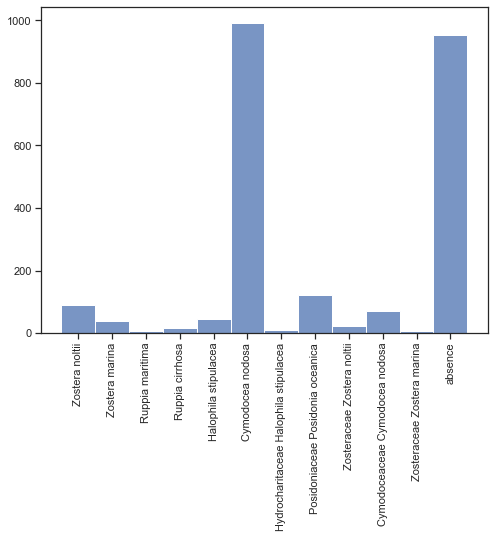

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style("ticks")

ax = sns.histplot(x='Species Name', data=data)
plt.setp(ax.get_xticklabels(), rotation=90)
#ax.set(xlim=(-0.1, 1.1))
ax.set(xlabel=None)
ax.set(ylabel=None)
#lgd = ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('figs/sea_hist_split.png', dpi=300, bbox_inches='tight')

In [17]:
pred_cols = data.columns[1:-1]
target_col = data.columns[0]
print('Prediction Variables: {0}'.format(pred_cols))
print('Target Variables: {0}'.format(target_col))

Prediction Variables: Index(['Temperature', 'Salinity', 'Chlorophyll', 'Nitrate',
       'Secchi Disk Depth', 'Phosphate', 'Wave Height', 'Water Depth',
       'Dist. to Major City', 'Dist. to City', 'Dist. to Port',
       'Dist. Major River', 'Dist. to River', 'Dist. to Coast'],
      dtype='object')
Target Variables: Species Name


In [18]:
# train/test split
test_frac = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(data[pred_cols], data[target_col],
                                          test_size= test_frac, random_state= 5,
                                          stratify=data[target_col])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1666, 14)
(714, 14)
(1666,)
(714,)


### Decision Trees

Be sure to use some form of pruning. 

In [13]:
t_tree = time()
dtree = DecisionTreeClassifier(criterion='gini', random_state = 0)
clf = dtree.fit(X_train, Y_train)
t_tree = time() - t_tree
t_tree

0.02215862274169922

In [14]:
print('The default tree depth is {0}'.format(clf.get_depth()))
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, clf.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, clf.predict(X_test))))

The default tree depth is 25
In Sample (Training) Accuracy : 0.9975990396158463
Out of Sample (Test) Accuracy : 0.6918767507002801


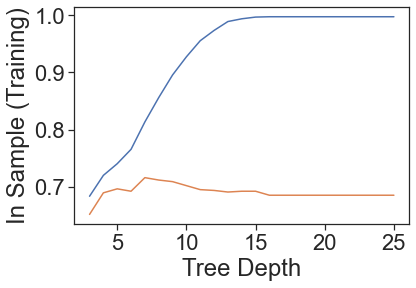

In [15]:
max_depth = clf.get_depth()

in_sample = []
out_sample = []
for depth in range(max_depth, 2, -1):
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state = 55)
    clf_trial = dtree.fit(X_train, Y_train)
    in_sample.append(accuracy_score(Y_train, clf_trial.predict(X_train)))
    out_sample.append(accuracy_score(Y_test, clf_trial.predict(X_test)))
    
accuracy_df = pd.DataFrame()
accuracy_df['In Sample (Training)'] = in_sample
accuracy_df['Out Sample (Test)'] = out_sample
accuracy_df['Tree Depth'] = list(range(max_depth, 2, -1))
sns.lineplot(x='Tree Depth', y= 'In Sample (Training)', data = accuracy_df)
sns.lineplot(x='Tree Depth', y= 'Out Sample (Test)', data = accuracy_df)
plt.show()

In [16]:
params = {'max_leaf_nodes': list(range(2, 100)), 'max_depth': np.linspace(2,25, 24)}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=55), 
                              params, verbose=1, cv=3)

grid_search_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7056 out of 7056 | elapsed:  1.3min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=55),
             param_grid={'max_depth': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...]},
             verbose=1)

In [17]:
dtree_best = grid_search_cv.best_estimator_
clf_best = dtree_best.fit(X_train, Y_train)
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, clf_best.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, clf_best.predict(X_test))))

In Sample (Training) Accuracy : 0.7995198079231692
Out of Sample (Test) Accuracy : 0.742296918767507


In [46]:
dtree_best

DecisionTreeClassifier(max_depth=11.0, max_leaf_nodes=42, random_state=55)

In [34]:
Y_pred = clf_best.predict(X_test)
print(classification_report(Y_test, Y_pred))

                                       precision    recall  f1-score   support

                     Cymodocea nodosa       0.72      0.87      0.79       298
       Cymodoceaceae Cymodocea nodosa       0.60      0.68      0.64        22
                 Halophila stipulacea       1.00      0.07      0.13        14
Hydrocharitaceae Halophila stipulacea       0.00      0.00      0.00         3
     Posidoniaceae Posidonia oceanica       0.69      0.50      0.58        36
                      Ruppia cirrhosa       0.00      0.00      0.00         5
                      Ruppia maritima       0.00      0.00      0.00         2
                       Zostera marina       0.00      0.00      0.00        12
                       Zostera noltii       0.65      0.48      0.55        27
           Zosteraceae Zostera marina       0.00      0.00      0.00         2
           Zosteraceae Zostera noltii       0.00      0.00      0.00         7
                              absence       0.80   

c:\users\janor\anaconda3\envs\cs7641\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


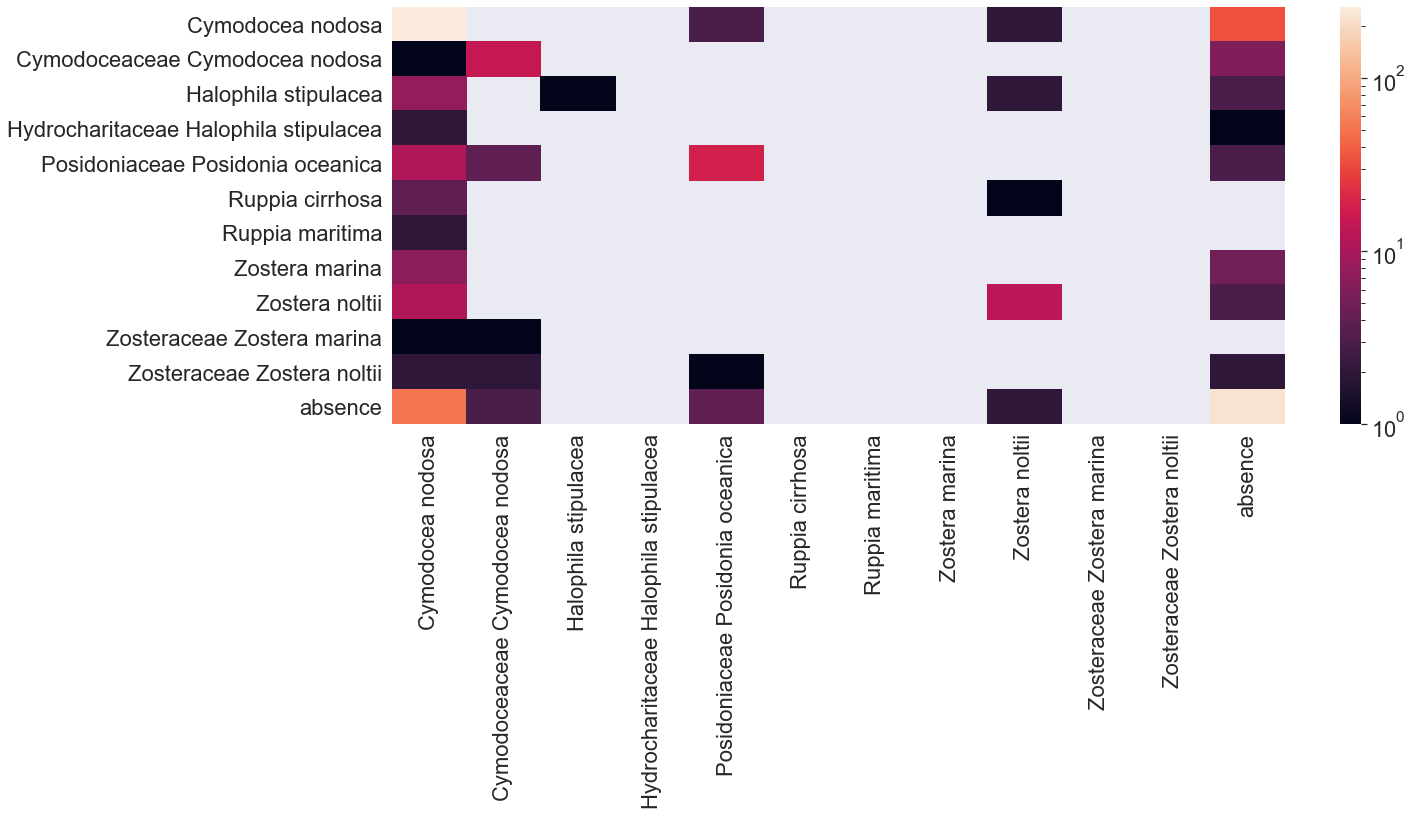

In [35]:
confusion = confusion_matrix(Y_test, Y_pred)
df_conf = pd.DataFrame(confusion, index = np.unique(data[target_col]), columns = np.unique(data[target_col]))

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)

sns.heatmap(df_conf, annot=False, norm=LogNorm(vmin=1, vmax=confusion.max()))
ax.set(xticks=[])
plt.savefig('figs/sea_rf_confusion.png', dpi=300)

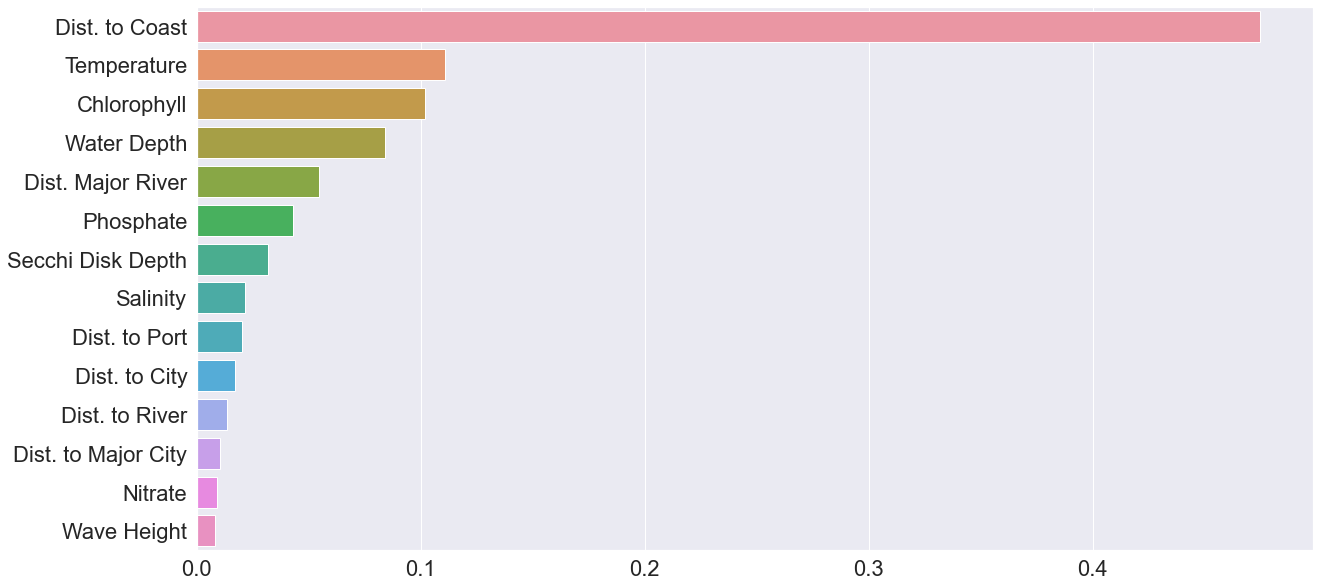

In [20]:
importance = clf_best.feature_importances_
## Sort in Ascending Feature Importance
ind_sort = np.argsort(importance)[::-1]
pred_cols_importance = pred_cols[ind_sort]
importance = importance[ind_sort]
ind_keep = np.where(importance>0)
ind_keep
pred_cols_importance[ind_keep]
## Plot Importance
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=importance, y=pred_cols_importance[ind_keep]) 
plt.savefig('figs/importance.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

### Neural Network

You may use networks of nodes with as many layers as you like and any activation function you see fit.

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, Y_train)
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, mlp.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, mlp.predict(X_test))))

In Sample (Training) Accuracy : 0.6230492196878752
Out of Sample (Test) Accuracy : 0.6064425770308123


In [29]:
mlp = MLPClassifier(max_iter=500)

parameter_space = {
    'hidden_layer_sizes': [(12,12,12), (15,30,15),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid_search_cv_mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
grid_search_cv_mlp.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(12, 12, 12), (15, 30, 15),
                                                (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [30]:
mlp_best = grid_search_cv_mlp.best_estimator_
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, mlp_best.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, mlp_best.predict(X_test))))

In Sample (Training) Accuracy : 0.6794717887154862
Out of Sample (Test) Accuracy : 0.6456582633053222


In [ ]:
np.load()

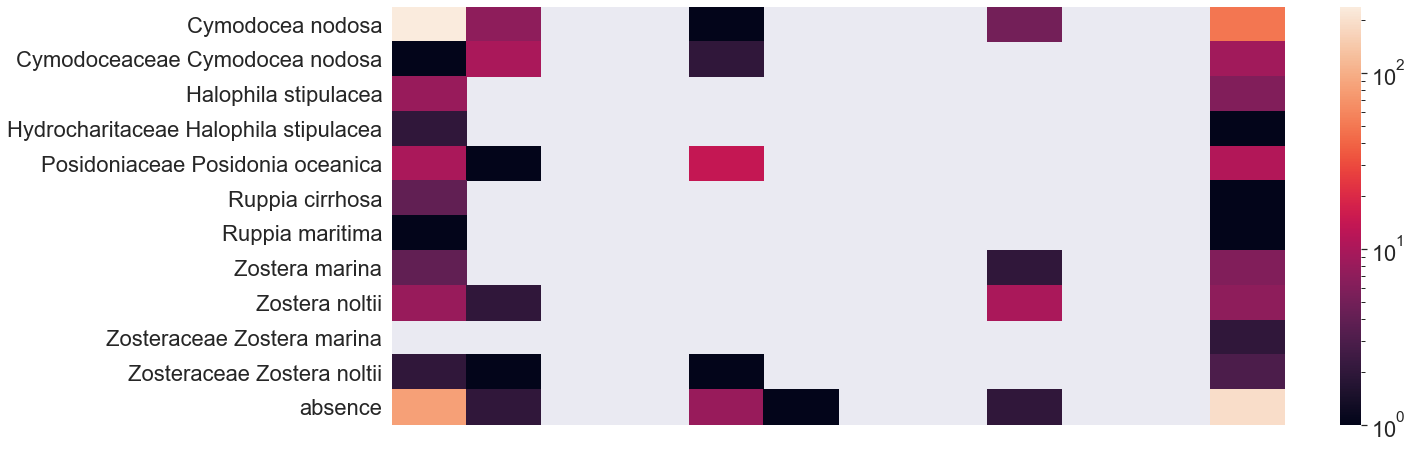

In [33]:
Y_pred = mlp_best.predict(X_test)
confusion = confusion_matrix(Y_test, Y_pred)
df_conf = pd.DataFrame(confusion, index = np.unique(data[target_col]), columns = np.unique(data[target_col]))

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)

ax = sns.heatmap(df_conf, annot=False, norm=LogNorm(vmin=1, vmax=confusion.max()))
ax.set(xticks=[])
plt.savefig('figs/sea_mlp_confusion.png', dpi=300)

In [86]:
Y_pred = mlp_best.predict(X_test)
print(classification_report(Y_test, Y_pred))

                                       precision    recall  f1-score   support

                     Cymodocea nodosa       0.66      0.79      0.72       298
       Cymodoceaceae Cymodocea nodosa       0.43      0.45      0.44        22
                 Halophila stipulacea       0.00      0.00      0.00        14
Hydrocharitaceae Halophila stipulacea       0.00      0.00      0.00         3
     Posidoniaceae Posidonia oceanica       0.54      0.39      0.45        36
                      Ruppia cirrhosa       0.00      0.00      0.00         5
                      Ruppia maritima       0.00      0.00      0.00         2
                       Zostera marina       0.00      0.00      0.00        12
                       Zostera noltii       0.53      0.37      0.43        27
           Zosteraceae Zostera marina       0.00      0.00      0.00         2
           Zosteraceae Zostera noltii       0.00      0.00      0.00         7
                              absence       0.67   

c:\users\janor\anaconda3\envs\cs7641\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Boosting

 Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

In [19]:
boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=0)
boost.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=200, random_state=0)

In [20]:
boost

GradientBoostingClassifier(n_estimators=200, random_state=0)

In [24]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, boost.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, boost.predict(X_test))))

In Sample (Training) Accuracy : 0.9975990396158463
Out of Sample (Test) Accuracy : 0.8053221288515406


In [48]:
parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.4, 0.5],
    "max_depth":np.linspace(5,20,16)
    }

grid_search_cv_boost = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

grid_search_cv_boost.fit(X_train, Y_train)

c:\users\janor\anaconda3\envs\cs7641\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4, 0.5],
                         'max_depth': array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20.])})

In [83]:
boost_best = grid_search_cv_boost.best_estimator_
boost_best 

GradientBoostingClassifier(learning_rate=0.4, max_depth=7.0)

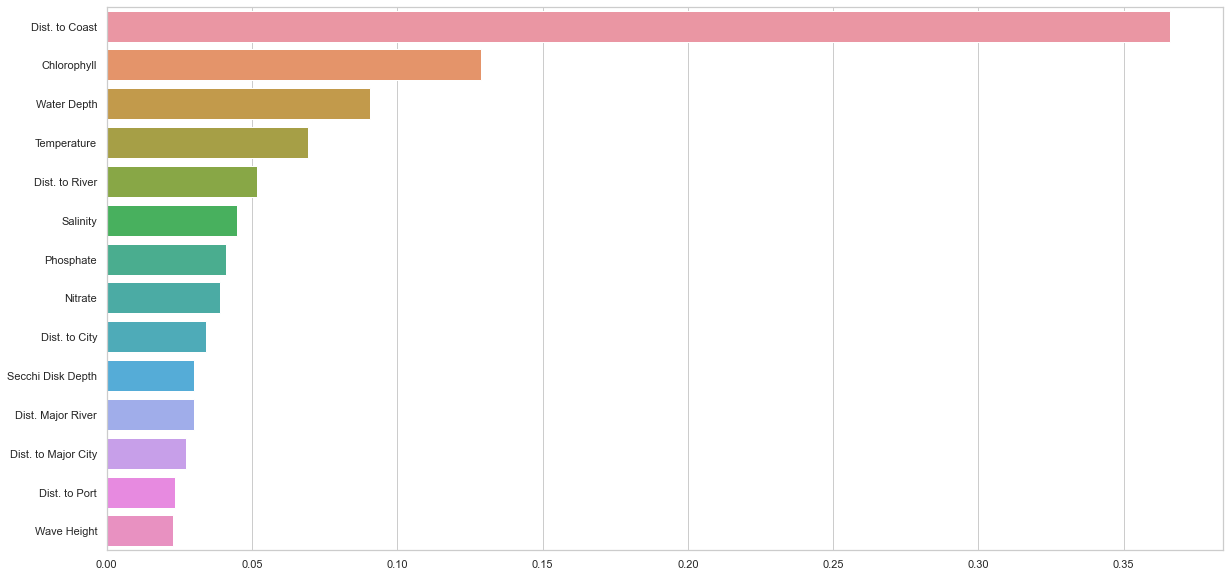

In [29]:
importance = boost.feature_importances_
## Sort in Ascending Feature Importance
ind_sort = np.argsort(importance)[::-1]
pred_cols_importance = pred_cols[ind_sort]
importance = importance[ind_sort]
ind_keep = np.where(importance>0)
ind_keep
pred_cols_importance[ind_keep]
## Plot Importance
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=importance, y=pred_cols_importance[ind_keep]) 
plt.savefig('figs/Boost_sea_importance.png', dpi=300, bbox_inches='tight')

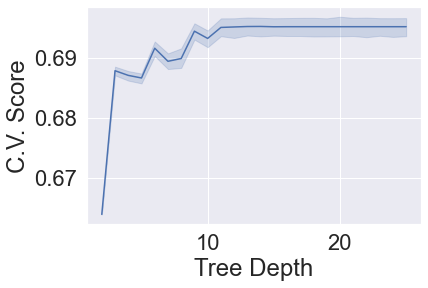

In [82]:
perf_df = pd.DataFrame()
perf_df['Tree Depth'] = grid_search_cv.cv_results_['param_max_depth'].data
perf_df['Max Leaf Nodes'] = grid_search_cv.cv_results_['param_max_leaf_nodes'].data
perf_df['C.V. Score'] = grid_search_cv.cv_results_['mean_test_score'].flatten()
sns.lineplot(x='Tree Depth', y= 'C.V. Score', data = perf_df)
#sns.lineplot(x='Max Leaf Nodes', y= 'C.V. Score', data = perf_df)
plt.show()

In [84]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, boost_best.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, boost_best.predict(X_test))))

In Sample (Training) Accuracy : 0.9975990396158463
Out of Sample (Test) Accuracy : 0.7955182072829131


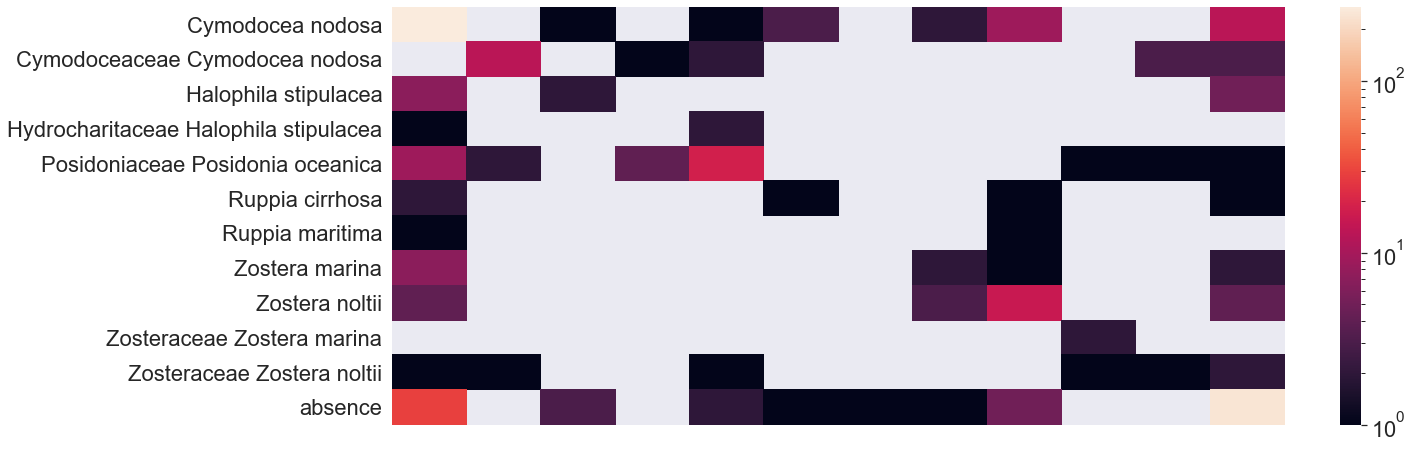

In [85]:
Y_pred = boost_best.predict(X_test)
confusion = confusion_matrix(Y_test, Y_pred)
df_conf = pd.DataFrame(confusion, index = np.unique(data[target_col]), columns = np.unique(data[target_col]))

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)

ax = sns.heatmap(df_conf, annot=False, norm=LogNorm(vmin=1, vmax=confusion.max()))
ax.set(xticks=[])
plt.savefig('figs/sea_boost_confusion.png', dpi=300)

In [87]:
Y_pred = boost_best.predict(X_test)
print(classification_report(Y_test, Y_pred))

                                       precision    recall  f1-score   support

                     Cymodocea nodosa       0.82      0.90      0.86       298
       Cymodoceaceae Cymodocea nodosa       0.81      0.59      0.68        22
                 Halophila stipulacea       0.33      0.14      0.20        14
Hydrocharitaceae Halophila stipulacea       0.00      0.00      0.00         3
     Posidoniaceae Posidonia oceanica       0.69      0.50      0.58        36
                      Ruppia cirrhosa       0.20      0.20      0.20         5
                      Ruppia maritima       0.00      0.00      0.00         2
                       Zostera marina       0.25      0.17      0.20        12
                       Zostera noltii       0.48      0.59      0.53        27
           Zosteraceae Zostera marina       0.50      1.00      0.67         2
           Zosteraceae Zostera noltii       0.20      0.14      0.17         7
                              absence       0.89   

### Support Vector Machines

swap out kernel functions. I'd like to see at least two.

In [9]:
t_svm = time()
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
svc.fit(X_train, Y_train)
t_svm = time() - t_svm
print('Support Vector Run Time : {0}'.format(t_svm))

Support Vector Run Time : 0.24105143547058105


In [23]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, svc.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, svc.predict(X_test))))

In Sample (Training) Accuracy : 0.5840336134453782
Out of Sample (Test) Accuracy : 0.5658263305322129


In [24]:
## Standardize the Data
X_train_svm = (X_train - data.mean())/data.std(ddof=1)
X_test_svm = (X_test - data.mean())/data.std(ddof=1)
## Fit on Standardized Data
t_svm = time()
svc = SVC(C=1.0, kernel='rbf', gamma='scale')
svc.fit(X_train_svm, Y_train)
t_svm = time() - t_svm
print('Support Vector Run Time : {0}'.format(t_svm))

Support Vector Run Time : 0.17106294631958008


In [25]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, svc.predict(X_train_svm))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, svc.predict(X_test_svm))))

In Sample (Training) Accuracy : 0.7382953181272509
Out of Sample (Test) Accuracy : 0.7030812324929971


In [29]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}]
grid_search_svm = GridSearchCV(SVC(), parameters, n_jobs=-1)
grid_search_svm.fit(X_train_svm, Y_train)
svc_rbf_best = grid_search_svm.best_estimator_

In [30]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, svc_rbf_best.predict(X_train_svm))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, svc_rbf_best.predict(X_test_svm))))

In Sample (Training) Accuracy : 0.7533013205282113
Out of Sample (Test) Accuracy : 0.7030812324929971


In [33]:
t_svm = time()
svc = SVC(C=1.0, kernel='poly', degree=3)
svc.fit(X_train_svm, Y_train)
t_svm = time() - t_svm
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, svc.predict(X_train_svm))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, svc.predict(X_test_svm))))

In Sample (Training) Accuracy : 0.6800720288115246
Out of Sample (Test) Accuracy : 0.6204481792717087


In [34]:
parameters = [{'kernel': ['poly'], 'degree': [1,2,3,4,5,6,7,8,9,10]}]
grid_search_svm = GridSearchCV(SVC(), parameters, n_jobs=-1)
grid_search_svm.fit(X_train_svm, Y_train)
svc_poly_best = grid_search_svm.best_estimator_

In [36]:
svc_poly_best

SVC(degree=1, kernel='poly')

In [35]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, svc_poly_best.predict(X_train_svm))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, svc_poly_best.predict(X_test_svm))))

In Sample (Training) Accuracy : 0.6680672268907563
Out of Sample (Test) Accuracy : 0.6470588235294118


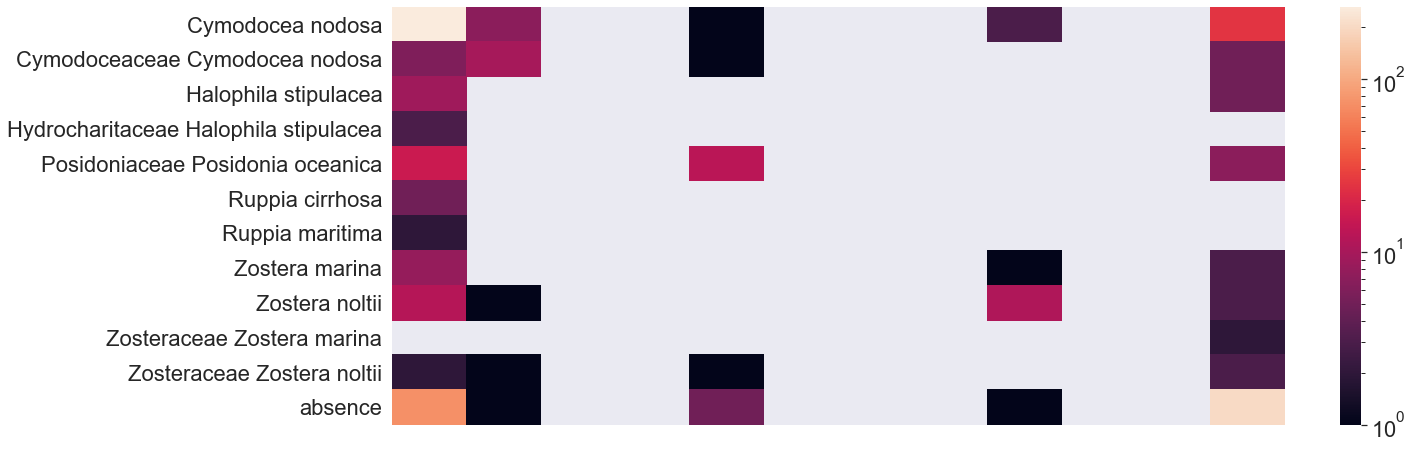

In [37]:
Y_pred = svc_rbf_best.predict(X_test_svm)
confusion = confusion_matrix(Y_test, Y_pred)

df_conf = pd.DataFrame(confusion, index = np.unique(data[target_col]), columns = np.unique(data[target_col]))

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)

ax = sns.heatmap(df_conf, annot=False, norm=LogNorm(vmin=1, vmax=confusion.max()))
ax.set(xticks=[])
plt.savefig('figs/sea_svm_confusion.png', dpi=300)

In [39]:
print(classification_report(Y_test, Y_pred))

                                       precision    recall  f1-score   support

                     Cymodocea nodosa       0.66      0.88      0.75       298
       Cymodoceaceae Cymodocea nodosa       0.50      0.45      0.48        22
                 Halophila stipulacea       0.00      0.00      0.00        14
Hydrocharitaceae Halophila stipulacea       0.00      0.00      0.00         3
     Posidoniaceae Posidonia oceanica       0.62      0.36      0.46        36
                      Ruppia cirrhosa       0.00      0.00      0.00         5
                      Ruppia maritima       0.00      0.00      0.00         2
                       Zostera marina       0.00      0.00      0.00        12
                       Zostera noltii       0.69      0.41      0.51        27
           Zosteraceae Zostera marina       0.00      0.00      0.00         2
           Zosteraceae Zostera noltii       0.00      0.00      0.00         7
                              absence       0.80   

c:\users\janor\anaconda3\envs\cs7641\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### k-Nearest Neighbors

Different values of k

In [49]:
t_k = time()
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', leaf_size=10, p=2)
knn.fit(X_train, Y_train)
t_k = time() - t_k
print('Support Vector Run Time : {0}'.format(t_svm))

Support Vector Run Time : 0.16356253623962402


In [50]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, knn.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, knn.predict(X_test))))

In Sample (Training) Accuracy : 0.7112845138055222
Out of Sample (Test) Accuracy : 0.6274509803921569


In [54]:
knn = KNeighborsClassifier()
parameters = dict(n_neighbors=list(range(1, 100)))
grid_search_knn = GridSearchCV(knn, parameters, cv=10, scoring='accuracy')
grid_search_knn.fit(X_train, Y_train)

c:\users\janor\anaconda3\envs\cs7641\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

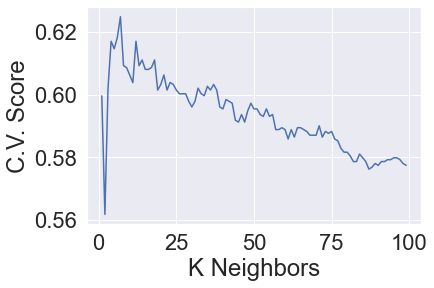

In [67]:
knn_best = grid_search_knn.best_estimator_
perf_df = pd.DataFrame()
perf_df['K Neighbors'] = grid_search_knn.cv_results_['param_n_neighbors']
perf_df['C.V. Score'] = grid_search_knn.cv_results_['mean_test_score']
sns.lineplot(x='K Neighbors', y= 'C.V. Score', data = perf_df)
plt.savefig('figs/sea_knn_opt.png', dpi=300)

In [68]:
print('In Sample (Training) Accuracy : {0}'.format(accuracy_score(Y_train, knn_best.predict(X_train))))
print('Out of Sample (Test) Accuracy : {0}'.format(accuracy_score(Y_test, knn_best.predict(X_test))))

In Sample (Training) Accuracy : 0.6902761104441777
Out of Sample (Test) Accuracy : 0.6414565826330533


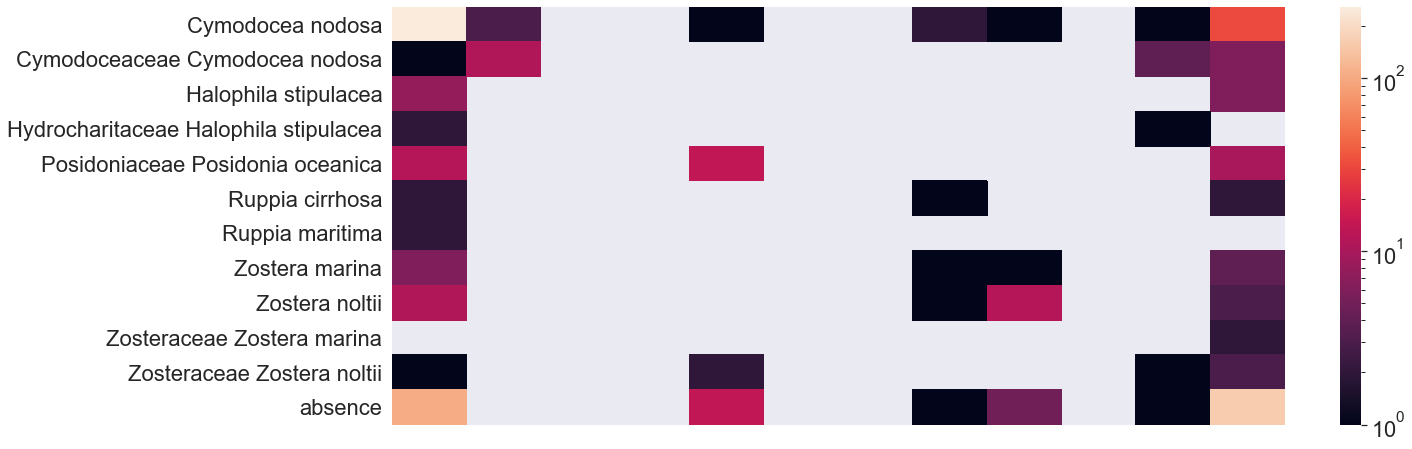

In [69]:
Y_pred = knn_best.predict(X_test)
confusion = confusion_matrix(Y_test, Y_pred)

df_conf = pd.DataFrame(confusion, index = np.unique(data[target_col]), columns = np.unique(data[target_col]))

sns.set(font_scale=2)
plt.figure(figsize=(20,10))
plt.gcf().subplots_adjust(bottom=0.30)

ax = sns.heatmap(df_conf, annot=False, norm=LogNorm(vmin=1, vmax=confusion.max()))
ax.set(xticks=[])
plt.savefig('figs/sea_knn_confusion.png', dpi=300)